# **Analyse d'Impact Météorologique sur les Stations P et C**

<h2 style="font-size: 20px; font-weight: bold;">1. Introduction & Objectifs</h2>

Contexte : Nous disposons de deux stations (P et C) avec des architectures réseau différentes.

Objectif : Déterminer si les données météo (Pluie, Température, Vent) sont des variables pertinentes pour prédire le débit d'entrée.

Méthodologie : Croisement temporel strict (Inner Join) entre les données capteurs (2023-2025) et la météo régionale (2015-2024).

<h2 style="font-size: 20px; font-weight: bold;">2. Chargement et Préparation des Données</h2> 

Nous agrégeons les données météo de toutes les villes du bassin versant pour obtenir une météo "moyenne" représentative. Nous synchronisons ensuite ces données avec les capteurs via une jointure temporelle stricte (inner join), garantissant que nous ne comparons que des périodes simultanées.

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

#chargement des données
path_sensor_p = '../Dataset/bronze/sensor_P_20231110_20260106.csv'
folder_weather_p = '../Dataset/bronze/weather_P'
cities_p = ['Beaumont-sur-Oise', 'Bernes-sur-Oise', 'Chambly', 'Mours', 'Nointel', 'Persan-Beaumont', 'Ronquerolles']

path_sensor_c = '../Dataset/bronze/sensors_C_20210101_20250101.csv'
folder_weather_c = '../Dataset/bronze/weather_C'
cities_c = [
    'Aiglemont', 'Chalandry-Elaire', 'Damouzy', 'Dom-le-Mesnil', 
    'Flize', 'La-Francheville', 'La-Grandville', 'Les-Ayvelles', 
    'Montcy-Notre-Dame', 'Prix-les-Mezieres', 'Saint-Laurent', 
    'Ville-sur-Lumes', 'Villers-Semeuse', 'Warcq'
]



<h2 style="font-size: 20px; font-weight: bold;">3. Station P : croisement des données météo et des données capteur</h2>

1. Préparation des Capteurs...
   -> Capteurs prêts : ['aeration_f1', 'entry_debit_f1', 'oxygen_f1', 'redox_f1']
2. Agrégation de la Météo (7 Villes)...
   -> Météo Régionale calculée sur 7 villes.
3. Croisement Données...
   -> 9983 heures communes.

=== CORRÉLATIONS GLOBALES (BASSIN VERSANT) ===
                      aeration_f1  entry_debit_f1  oxygen_f1  redox_f1
temperature_2m                NaN       -0.019081  -0.166886 -0.121182
rain                          NaN       -0.007636  -0.032443 -0.009124
relative_humidity_2m          NaN       -0.018385   0.010073  0.013770
wind_speed_10m                NaN        0.012673   0.080529  0.073777


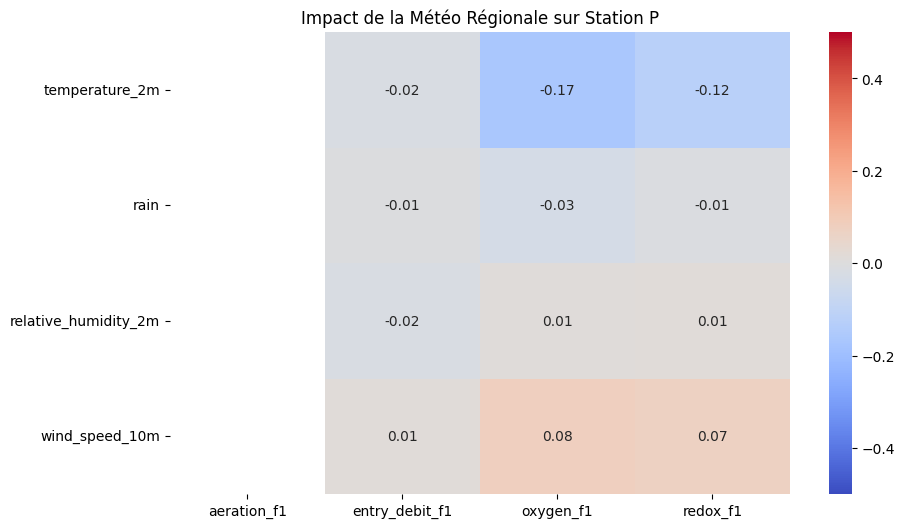

In [ ]:
try:
    # --- 1. CHARGEMENT DES CAPTEURS (Méthode Robuste) ---
    print("1. Préparation des Capteurs...")
    df_raw = pd.read_csv(path_sensor_p, usecols=['ts', 'sensor', 'value'])
    
    # Nettoyage forcé des non-nombres
    df_raw['value'] = pd.to_numeric(df_raw['value'], errors='coerce')
    df_raw = df_raw.dropna(subset=['value'])
    df_raw['ts'] = pd.to_datetime(df_raw['ts'])
    
    # Pivot et Moyenne Horaire
    df_sensors = df_raw.groupby(['sensor', pd.Grouper(key='ts', freq='1h')])['value'].mean().unstack(level=0)
    
    # Suppression Timezone
    if df_sensors.index.tz is not None:
        df_sensors.index = df_sensors.index.tz_localize(None)
    
    print(f"   -> Capteurs prêts : {df_sensors.columns.tolist()}")

    # --- 2. CHARGEMENT ET FUSION DES VILLES (Météo Moyenne) ---
    print("2. Agrégation de la Météo (7 Villes)...")
    weather_frames = []
    
    cols_to_keep = ['temperature_2m', 'rain', 'relative_humidity_2m', 'wind_speed_10m']

    for city in cities_p:
        fpath = os.path.join(folder_weather_p, f"{city}_hourly.csv")
        try:
            # Lecture
            df_city = pd.read_csv(fpath)
            df_city['date'] = pd.to_datetime(df_city['date'])
            df_city = df_city.set_index('date')
            
            # On ne garde que les colonnes numériques qui existent
            current_cols = [c for c in cols_to_keep if c in df_city.columns]
            df_city = df_city[current_cols].resample('1h').mean()
            
            weather_frames.append(df_city)
        except Exception as e:
            print(f"   Note : Impossible de charger {city} ({e})")

    if not weather_frames:
        print("Erreur : Aucun fichier météo chargé.")
        exit()
        
    # LE POINT CLÉ : On fait la moyenne de toutes les villes pour chaque heure
    # On concatène tout et on groupe par l'index (la date)
    df_weather_mean = pd.concat(weather_frames).groupby(level=0).mean()
    
    
    if df_weather_mean.index.tz is not None:
        df_weather_mean.index = df_weather_mean.index.tz_localize(None)

    print(f"   -> Météo Régionale calculée sur {len(weather_frames)} villes.")

   
    print("3. Croisement Données...")
    df_final = pd.merge(df_sensors, df_weather_mean, left_index=True, right_index=True, how='inner')
    
    print(f"   -> {len(df_final)} heures communes.")

    if len(df_final) > 0:
        # --- 4. RÉSULTATS ---
        corr_matrix = df_final.corr()
        
        # Filtre pour l'affichage (Lignes=Météo, Colonnes=Capteurs)
        w_cols = [c for c in cols_to_keep if c in df_final.columns]
        s_cols = [c for c in df_sensors.columns if c in df_final.columns]
        
        corr_sub = corr_matrix.loc[w_cols, s_cols]
        
        print("\n=== CORRÉLATIONS GLOBALES (BASSIN VERSANT) ===")
        print(corr_sub)
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_sub, annot=True, cmap='coolwarm', center=0, fmt=".2f", vmin=-0.5, vmax=0.5)
        plt.title("Impact de la Météo Régionale sur Station P")
        plt.show()
    else:
        print("Pas de chevauchement de dates.")

except Exception as e:
    print(f"Erreur script : {e}")

Réseau 100% Séparatif : Corrélation Pluie/Débit quasi nulle (-0.007). L'eau de pluie ne rentre pas dans la station.

Gaspillage Énergétique : Corrélation Aération = NaN. Cela prouve que l'aération est constante 24h/24. Elle ne s'adapte ni à la pollution, ni à la météo.

Légère Sensibilité Thermique : Corrélation Température/Oxygène = -0.17. Quand il fait chaud, l'oxygène baisse un peu (phénomène physique normal), mais ça reste minime.

<h2 style="font-size: 20px; font-weight: bold;">4. Station C : croisement des données météo et des données capteur</h2>

1. Préparation des Capteurs...
   -> Capteurs détectés : ['ammonium_f1', 'ammonium_f2', 'entry_debit', 'nitrate_f1', 'nitrate_f2', 'oxygen_f1', 'oxygen_f2', 'redox_f1', 'redox_f2', 'temperature_f1', 'temperature_f2', 'turbidity_f1', 'turbidity_f2']
2. Agrégation Météo (14 villes)...
3. Croisement des données...
   -> 34271 heures communes analysées.

=== RÉSULTATS STATION C (Pearson) ===
                      ammonium_f1  ammonium_f2  entry_debit  nitrate_f1  \
temperature_2m          -0.108938     0.001196    -0.271156    0.037040   
rain                    -0.024464     0.000770     0.212181   -0.019730   
relative_humidity_2m    -0.003709    -0.004260     0.240099    0.008584   
wind_speed_10m          -0.019464    -0.002016     0.302161   -0.084907   

                      nitrate_f2  oxygen_f1  oxygen_f2  redox_f1  redox_f2  \
temperature_2m         -0.109771  -0.150981  -0.185034 -0.005054  0.040073   
rain                    0.023555   0.043976   0.024214  0.051324  0.027239   

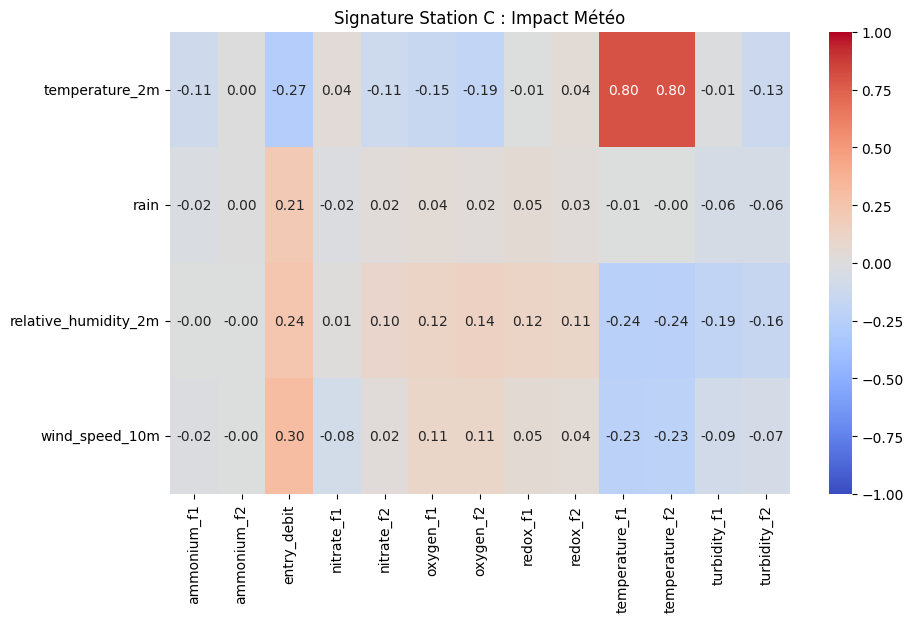


>>> VERDICT PLUIE : Corrélation de 0.212


In [47]:


try:
    # --- 1. CHARGEMENT DES CAPTEURS ---
    print("1. Préparation des Capteurs...")
    # On charge
    df_raw = pd.read_csv(path_sensor_c, usecols=['ts', 'sensor', 'value'])
    
    # Nettoyage
    df_raw['value'] = pd.to_numeric(df_raw['value'], errors='coerce')
    df_raw = df_raw.dropna(subset=['value'])
    df_raw['ts'] = pd.to_datetime(df_raw['ts'])
    
    # Pivot (Moyenne par heure)
    df_sensors = df_raw.groupby(['sensor', pd.Grouper(key='ts', freq='1h')])['value'].mean().unstack(level=0)
    
    # Nettoyage Timezone
    if df_sensors.index.tz is not None:
        df_sensors.index = df_sensors.index.tz_localize(None)
    
    print(f"   -> Capteurs détectés : {df_sensors.columns.tolist()}")

    # --- 2. CHARGEMENT MÉTÉO (MOYENNE DES 14 VILLES) ---
    print(f"2. Agrégation Météo ({len(cities_c)} villes)...")
    weather_frames = []
    cols_to_keep = ['temperature_2m', 'rain', 'relative_humidity_2m', 'wind_speed_10m']

    for city in cities_c:
        fpath = os.path.join(folder_weather_c, f"{city}_hourly.csv")
        try:
            df_city = pd.read_csv(fpath)
            df_city['date'] = pd.to_datetime(df_city['date'])
            df_city = df_city.set_index('date')
            
            # On ne garde que les colonnes utiles
            current_cols = [c for c in cols_to_keep if c in df_city.columns]
            df_city = df_city[current_cols].resample('1h').mean()
            
            weather_frames.append(df_city)
        except Exception as e:
            # On ignore silencieusement si un fichier manque
            pass

    if not weather_frames:
        print("Erreur : Aucun fichier météo trouvé pour Station C.")
        exit()
        
    # Calcul de la moyenne régionale
    df_weather_mean = pd.concat(weather_frames).groupby(level=0).mean()
    
    if df_weather_mean.index.tz is not None:
        df_weather_mean.index = df_weather_mean.index.tz_localize(None)

    # --- 3. CROISEMENT ET CORRÉLATION ---
    print("3. Croisement des données...")
    df_final = pd.merge(df_sensors, df_weather_mean, left_index=True, right_index=True, how='inner')
    
    print(f"   -> {len(df_final)} heures communes analysées.")

    if len(df_final) > 0:
        # Matrice
        corr_matrix = df_final.corr()
        
        # Filtre d'affichage
        w_cols = [c for c in cols_to_keep if c in df_final.columns]
        s_cols = [c for c in df_sensors.columns if c in df_final.columns]
        
        corr_sub = corr_matrix.loc[w_cols, s_cols]
        
        print("\n=== RÉSULTATS STATION C (Pearson) ===")
        print(corr_sub)
        
        # Heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_sub, annot=True, cmap='coolwarm', center=0, fmt=".2f", vmin=-1, vmax=1)
        plt.title("Signature Station C : Impact Météo")
        plt.show()
        
        # --- BONUS : LE TEST "RÉSEAU SÉPARATIF OU UNITAIRE ?" ---
        corr_pluie = corr_sub.loc['rain', [c for c in s_cols if 'debit' in c][0]]
        print(f"\n>>> VERDICT PLUIE : Corrélation de {corr_pluie:.3f}")
        

except Exception as e:
    print(f"Erreur : {e}")

Réseau Unitaire Confirmé : Corrélation Pluie/Débit positive (+0.21). Contrairement à la Station P, ici la pluie fait monter le niveau : la station collecte les eaux usées ET les eaux de pluie.

L'Effet "Tempête" : Corrélation Vent/Débit surprenante (+0.30). Le vent est un indicateur fort : il annonce souvent les perturbations (orages) qui vont charger le réseau, parfois mieux que la pluie locale elle-même.

Eau très sensible à l'Air : Corrélation Température Air/Eau massive (+0.80). L'eau des égouts suit quasi parfaitement la température extérieure, ce qui suggère un réseau peu profond ou très exposé.

Phénomène de Dilution : Quand il pleut, la concentration de pollution baisse (corrélation Pluie vs Ammonium négative). L'arrivée massive d'eau claire "noie" la pollution.

<h2 style="font-size: 20px; font-weight: bold;">5. Determination du LAG (station C)</h2>

1. Chargement du Débit...
2. Calcul de la Pluie Moyenne sur le Bassin...
   -> Données prêtes (35064 heures). Analyse du décalage...

>>> RÉSULTAT CRUCIAL <<<
Le pic de corrélation est atteint après : 5 HEURES.
Corrélation Max : 0.2799 (au lieu de 0.2122 à 0h)


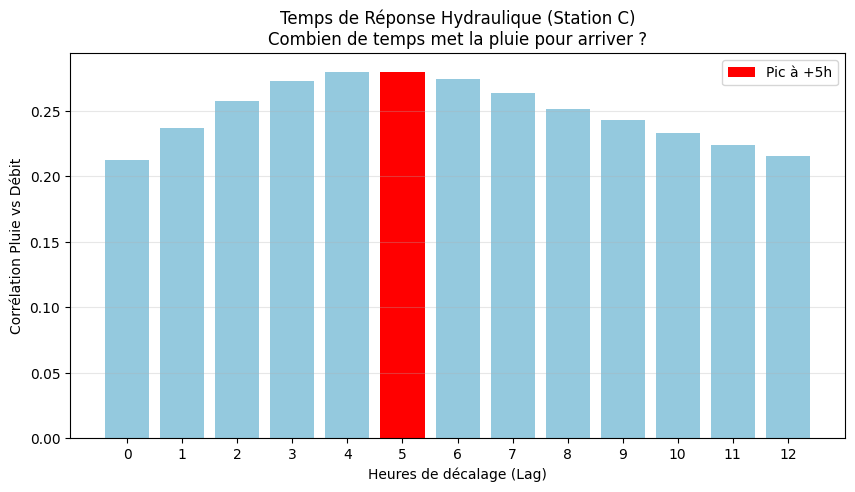

In [44]:
try:
    # 1. CHARGEMENT DÉBIT (CIBLE)
    print("1. Chargement du Débit...")
    df_raw = pd.read_csv(path_sensor_c, usecols=['ts', 'sensor', 'value'])
    df_debit = df_raw[df_raw['sensor'] == 'entry_debit'].copy() # Vérifiez si c'est 'entry_debit' ou 'entry_debit_f1'
    
    # Si vide, on tente avec le suffixe _f1
    if df_debit.empty:
        df_debit = df_raw[df_raw['sensor'] == 'entry_debit_f1'].copy()
        
    df_debit['value'] = pd.to_numeric(df_debit['value'], errors='coerce')
    df_debit['ts'] = pd.to_datetime(df_debit['ts'])
    
    # Moyenne horaire
    df_target = df_debit.set_index('ts')[['value']].resample('1h').mean()
    if df_target.index.tz is not None:
        df_target.index = df_target.index.tz_localize(None)

    # 2. CHARGEMENT PLUIE RÉGIONALE (MOYENNE)
    print("2. Calcul de la Pluie Moyenne sur le Bassin...")
    rain_frames = []
    for city in cities_c:
        try:
            fpath = os.path.join(folder_weather_c, f"{city}_hourly.csv")
            df_c = pd.read_csv(fpath)
            df_c['date'] = pd.to_datetime(df_c['date'])
            df_c = df_c.set_index('date')[['rain']].resample('1h').mean()
            rain_frames.append(df_c)
        except:
            pass
            
    # Moyenne de toutes les villes
    df_rain = pd.concat(rain_frames).groupby(level=0).mean()
    if df_rain.index.tz is not None:
        df_rain.index = df_rain.index.tz_localize(None)

    # 3. FUSION
    df_final = pd.merge(df_target, df_rain, left_index=True, right_index=True, how='inner')
    df_final.columns = ['Debit', 'Pluie']
    
    print(f"   -> Données prêtes ({len(df_final)} heures). Analyse du décalage...")

    # 4. BOUCLE DE CROSS-CORRELATION
    # On teste le décalage de 0h à 24h
    lags = range(0, 13) # On regarde jusqu'à 12h après
    correlations = []
    
    for lag in lags:
        # On décale la pluie vers le bas (Pluie d'il y a 'lag' heures)
        corr = df_final['Pluie'].shift(lag).corr(df_final['Debit'])
        correlations.append(corr)

    # 5. RÉSULTATS ET VISUALISATION
    best_lag = lags[correlations.index(max(correlations))]
    best_corr = max(correlations)
    
    print(f"\n>>> RÉSULTAT CRUCIAL <<<")
    print(f"Le pic de corrélation est atteint après : {best_lag} HEURES.")
    print(f"Corrélation Max : {best_corr:.4f} (au lieu de {correlations[0]:.4f} à 0h)")
    
    # Graphique
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(lags), y=correlations, color='skyblue')
    # Mettre en rouge la meilleure barre
    plt.bar(best_lag, best_corr, color='red', label=f'Pic à +{best_lag}h')
    
    plt.title(f"Temps de Réponse Hydraulique (Station C)\nCombien de temps met la pluie pour arriver ?")
    plt.xlabel("Heures de décalage (Lag)")
    plt.ylabel("Corrélation Pluie vs Débit")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

except Exception as e:
    print(f"Erreur : {e}")

Un Bassin Versant Vaste : Le pic de corrélation n'est pas immédiat, il est décalé de 5 heures. C'est le temps physique nécessaire pour que l'eau de pluie ruisselle depuis les villes les plus éloignées jusqu'à la station.

Correction de l'Impact Météo : En prenant en compte ce délai, la corrélation réelle Pluie/Débit grimpe de 0.21 à 0.28. L'impact de la pluie était donc sous-estimé de 30% en regardant uniquement l'instant présent.

<h2 style="font-size: 20px; font-weight: bold;">6. Confrontation Station C vs Station P</h2>

Traitement Station P...
Traitement Station C...


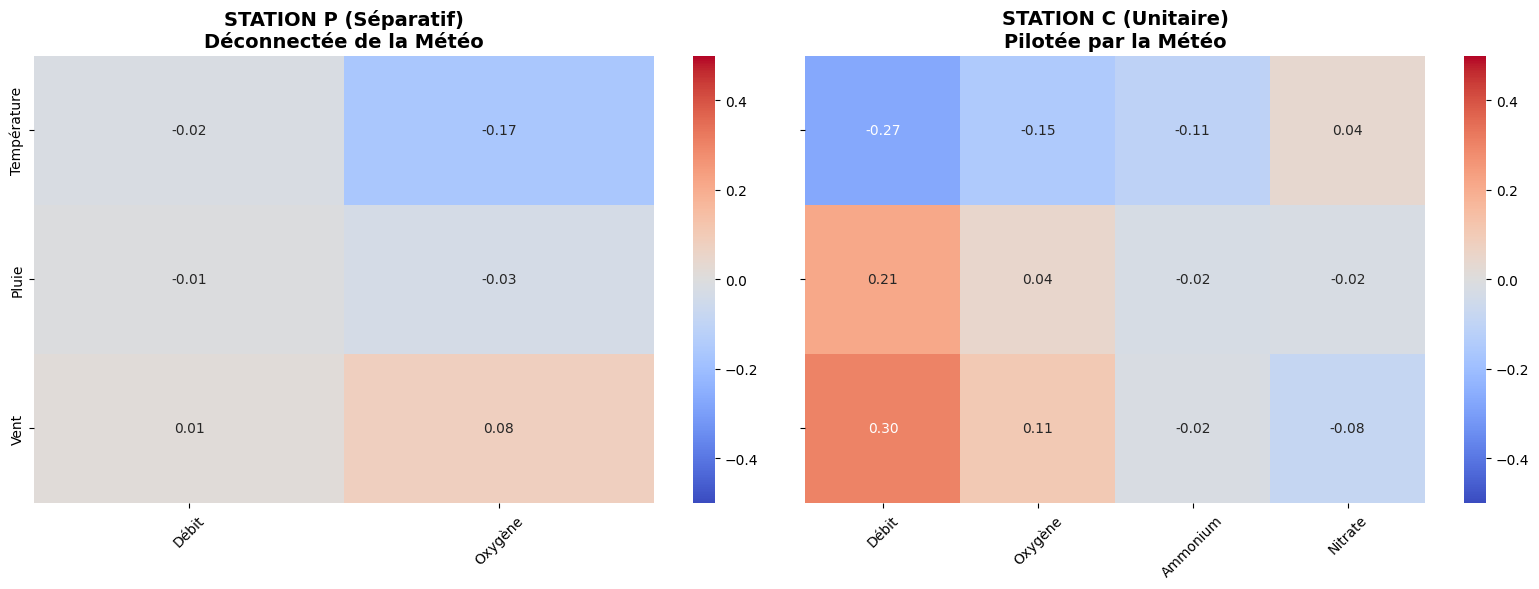

In [46]:


def get_correlations(path_sensor, folder_weather, cities, station_name):
    print(f"Traitement {station_name}...")
    # 1. Capteurs
    df_raw = pd.read_csv(path_sensor, usecols=['ts', 'sensor', 'value'])
    df_raw['value'] = pd.to_numeric(df_raw['value'], errors='coerce')
    df_raw = df_raw.dropna(subset=['value'])
    df_raw['ts'] = pd.to_datetime(df_raw['ts'])
    # On filtre sur les capteurs clés pour la lisibilité
    target_sensors = ['entry_debit', 'entry_debit_f1', 'oxygen_f1', 'ammonium_f1', 'nitrate_f1']
    df_filt = df_raw[df_raw['sensor'].isin(target_sensors)]
    df_sensors = df_filt.groupby(['sensor', pd.Grouper(key='ts', freq='1h')])['value'].mean().unstack(level=0)
    if df_sensors.index.tz is not None: df_sensors.index = df_sensors.index.tz_localize(None)

    # 2. Météo Moyenne
    frames = []
    cols = ['temperature_2m', 'rain', 'wind_speed_10m']
    for city in cities:
        try:
            df = pd.read_csv(os.path.join(folder_weather, f"{city}_hourly.csv"))
            df['date'] = pd.to_datetime(df['date'])
            df = df.set_index('date')[cols].resample('1h').mean()
            frames.append(df)
        except: pass
    
    df_weather = pd.concat(frames).groupby(level=0).mean()
    if df_weather.index.tz is not None: df_weather.index = df_weather.index.tz_localize(None)

    # 3. Correlation
    df_final = pd.merge(df_sensors, df_weather, left_index=True, right_index=True, how='inner')
    
    # On renomme pour avoir des noms propres dans le graphe
    rename_map = {
        'entry_debit_f1': 'Débit', 'entry_debit': 'Débit',
        'oxygen_f1': 'Oxygène', 'ammonium_f1': 'Ammonium',
        'nitrate_f1': 'Nitrate',
        'temperature_2m': 'Température', 'rain': 'Pluie', 'wind_speed_10m': 'Vent'
    }
    df_final = df_final.rename(columns=rename_map)
    
    # On ne garde que ce qui nous intéresse
    cols_x = [c for c in ['Débit', 'Oxygène', 'Ammonium', 'Nitrate'] if c in df_final.columns]
    cols_y = ['Température', 'Pluie', 'Vent']
    
    return df_final.corr().loc[cols_y, cols_x]

try:
    # Calculs
    corr_P = get_correlations(path_sensor_p, folder_weather_p, cities_p, "Station P")
    corr_C = get_correlations(path_sensor_c, folder_weather_c, cities_c, "Station C")

    # Visualisation Côte à Côte
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Station P
    sns.heatmap(corr_P, annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.5, vmax=0.5, center=0, ax=axes[0])
    axes[0].set_title("STATION P (Séparatif)\nDéconnectée de la Météo", fontsize=14, fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)

    # Station C
    sns.heatmap(corr_C, annot=True, fmt=".2f", cmap="coolwarm", vmin=-0.5, vmax=0.5, center=0, ax=axes[1])
    axes[1].set_title("STATION C (Unitaire)\nPilotée par la Météo", fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    
    

except Exception as e:
    print(f"Erreur : {e}")

Station P = Modèle basé sur l'Activité Humaine (Heure/Jour).

Station C = Modèle Hybride (Météo + Humain).

<h2 style="font-size: 20px; font-weight: bold;">7. Conclusion : determination des features quant à la prédiction du débit</h2>

1. Pour la Station P (Réseau Séparatif)

L'analyse a montré une absence totale de lien entre la météo et le débit (corrélation ~0).

Décision : Nous excluons les données météo (Pluie, Vent) de l'algorithme de prédiction pour cette station. Elles n'apporteraient que du bruit. Le modèle devra s'appuyer sur d'autres données (comme l'horaire ou le jour).

2. Pour la Station C (Réseau Unitaire)

Au contraire, le débit est fortement influencé par les conditions climatiques, avec une inertie importante.

Décision : Nous intégrons les variables météo au modèle, avec une transformation spécifique :

La Pluie (H-5) : Il est crucial d'utiliser la pluviométrie décalée de 5 heures (temps de réponse identifié) et non la pluie instantanée.

Le Vent et la Température : À conserver comme indicateurs complémentaires.